# Введение

## Цель проекта

разработать модель машинного обучения для предсказания судьбы стартапов

## Загрузка библиотек

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures #, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42

In [5]:
!pip install phik

import phik

In [6]:
!pip install shap
import shap


In [7]:
!pip install lightgbm
from lightgbm import LGBMClassifier

In [8]:
!pip install catboost
from catboost import CatBoostClassifier


# 1. Загрузка и ознакомление с данными

In [10]:
train_data = pd.read_csv('C:/Users/levle/OneDrive/Documents/Yandex_Practicum_main/Master1/M1_DS - Startups (STD)/kaggle_startups_train_28062024.csv', sep=',')
test_data = pd.read_csv('C:/Users/levle/OneDrive/Documents/Yandex_Practicum_main/Master1/M1_DS - Startups (STD)/kaggle_startups_test_28062024.csv', sep=',')

In [11]:
train_data.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [12]:
test_data.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


## Вывод

Данные загруженны, проблем с разделителем нет

# 2. Предварительная обработка

## train data

In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [17]:
train_data['founded_at'] = pd.to_datetime(train_data['founded_at'], errors='coerce')
train_data['first_funding_at'] = pd.to_datetime(train_data['first_funding_at'], errors='coerce')
train_data['last_funding_at'] = pd.to_datetime(train_data['last_funding_at'], errors='coerce')

In [18]:
train_data.describe()

,funding_total_usd,funding_rounds,founded_at,first_funding_at,last_funding_at
count,4.244700e+04,52516.000000,52516,52516,52516
mean,1.824748e+07,1.740670,2008-11-04 09:44:16.196206848,2011-07-17 04:45:33.247010304,2012-06-27 16:29:42.313961472
min,1.000000e+00,1.000000,1970-02-05 00:00:00,1977-05-15 00:00:00,1977-05-15 00:00:00
25%,3.360275e+05,1.000000,2006-10-01 00:00:00,2009-10-12 00:00:00,2011-02-01 00:00:00
50%,2.000000e+06,1.000000,2010-10-01 00:00:00,2012-07-23 00:00:00,2013-08-30 00:00:00
75%,1.000000e+07,2.000000,2013-01-01 00:00:00,2014-04-01 00:00:00,2014-11-17 00:00:00
max,3.007950e+10,19.000000,2016-04-02 00:00:00,2015-12-05 00:00:00,2015-12-07 00:00:00
std,1.871173e+08,1.374522,NaN,NaN,NaN


In [19]:
train_data['funding_total_usd'].max()

30079503000.0

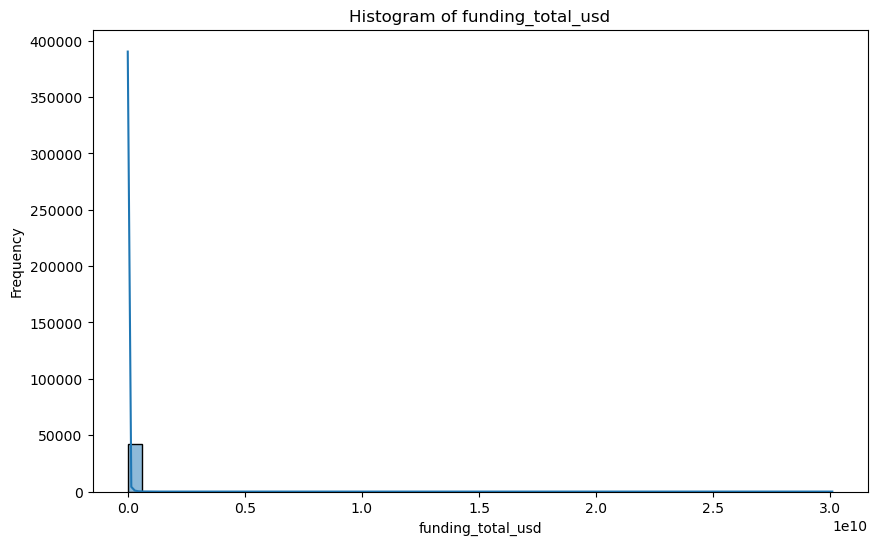

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['funding_total_usd'], bins=50, kde=True)
plt.title('Histogram of funding_total_usd')
plt.xlabel('funding_total_usd')
plt.ylabel('Frequency')
plt.show()

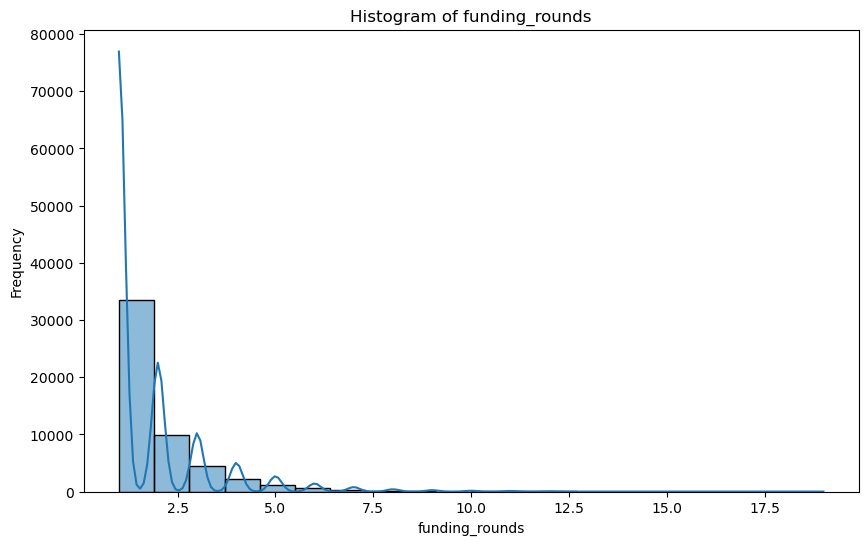

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['funding_rounds'], bins=20, kde=True)
plt.title('Histogram of funding_rounds')
plt.xlabel('funding_rounds')
plt.ylabel('Frequency')
plt.show()

In [22]:
##train_data[train_data['category_list'].isnull()].info()

In [23]:
duplicates = train_data.duplicated()
duplicated_rows = train_data[duplicates]
duplicated_rows.count()

name                 0
category_list        0
funding_total_usd    0
status               0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
founded_at           0
first_funding_at     0
last_funding_at      0
closed_at            0
dtype: int64

### Вывод 

есть пропуски, явных дупликатов нет. Видно что есть несколько проектов с очень большим финансированием и большим количеством роундов сбора

с размером финансирования нужно будет что-то делать если стараться оставить всю дату

## test data

In [26]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [27]:
duplicates = test_data.duplicated()
duplicated_rows = test_data[duplicates]
duplicated_rows.count()

name                 0
category_list        0
funding_total_usd    0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
first_funding_at     0
last_funding_at      0
lifetime             0
dtype: int64

In [28]:
test_data['first_funding_at'] = pd.to_datetime(test_data['first_funding_at'], errors='coerce')
test_data['last_funding_at'] = pd.to_datetime(test_data['last_funding_at'], errors='coerce')

In [29]:
test_data.describe()

,funding_total_usd,funding_rounds,first_funding_at,last_funding_at,lifetime
count,1.054700e+04,13125.000000,13125,13125,13125.000000
mean,1.654910e+07,1.714438,2011-07-23 20:54:08.640000,2012-06-16 05:03:41.348571392,3097.609524
min,1.000000e+00,1.000000,1973-04-15 00:00:00,1973-04-15 00:00:00,52.000000
25%,3.200000e+05,1.000000,2009-11-16 00:00:00,2011-01-10 00:00:00,1726.000000
50%,2.000000e+06,1.000000,2012-08-01 00:00:00,2013-08-21 00:00:00,2526.000000
75%,1.000000e+07,2.000000,2014-04-01 00:00:00,2014-11-11 00:00:00,3866.000000
max,4.715000e+09,15.000000,2015-12-03 00:00:00,2015-12-12 00:00:00,17167.000000
std,9.217283e+07,1.318800,NaN,NaN,2128.356554


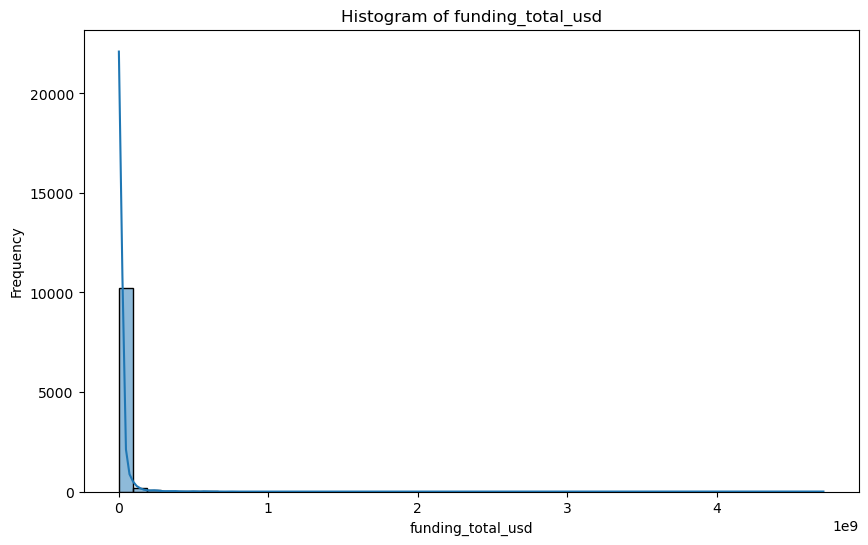

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(test_data['funding_total_usd'], bins=50, kde=True)
plt.title('Histogram of funding_total_usd')
plt.xlabel('funding_total_usd')
plt.ylabel('Frequency')
plt.show()

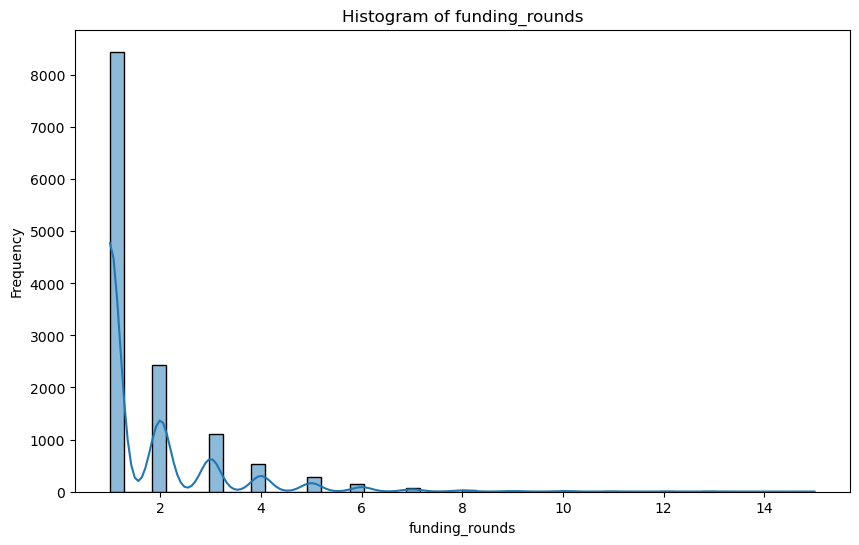

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(test_data['funding_rounds'], bins=50, kde=True)
plt.title('Histogram of funding_rounds')
plt.xlabel('funding_rounds')
plt.ylabel('Frequency')
plt.show()

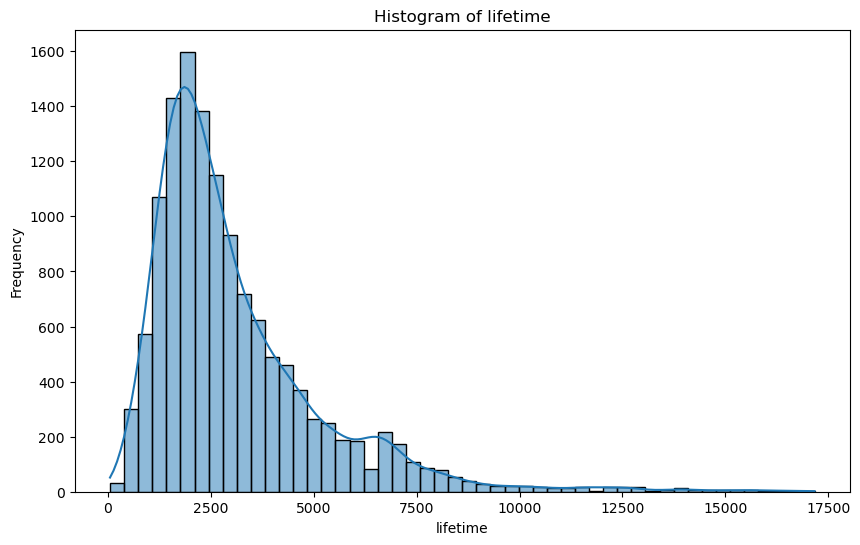

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(test_data['lifetime'], bins=50, kde=True)
plt.title('Histogram of lifetime')
plt.xlabel('lifetime')
plt.ylabel('Frequency')
plt.show()

### Вывод 

есть пропуски, явных дупликатов нет. Видно что есть несколько проектов с очень большим финансированием и большим количеством роундов сбора

с размером финансирования нужно будет что-то делать если стараться оставить всю дату

## Заполнение пропущенных колонок

train_data has status, founded_at, and closed_at, which are missing in test_data.

test_data has lifetime, which is missing in train_data.

Статус это таргет

Founded_at можно высчитать используя lifetime в test_data

lifetime с помощью founded_at в train_data

In [36]:
train_data['extract_date'] = pd.to_datetime('2018-01-01')

In [37]:
test_data['extract_date'] = pd.to_datetime('2018-01-01')

In [38]:
train_data['founded_at'] = pd.to_datetime(train_data['founded_at'], errors='coerce')

In [39]:
train_data['lifetime'] = np.where(
    train_data['closed_at'].isnull(),
    (train_data['extract_date'] - train_data['founded_at']).dt.days,  # If closed_at is null, use extract_date
    (pd.to_datetime(train_data['closed_at']) - train_data['founded_at']).dt.days  # Otherwise, use closed_at
)

In [40]:
test_data['founded_at'] = test_data['extract_date'] - pd.to_timedelta(test_data['lifetime'], unit='D')

In [41]:
test_data['source'] = 'test_data'
train_data['source'] = 'train_data'

# 3. Чистка, обработка пропусков и создание синтетических признаков

In [43]:
combined_data = pd.concat([train_data, test_data], ignore_index=True)

In [44]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65641 entries, 0 to 65640
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               65640 non-null  object        
 1   category_list      62585 non-null  object        
 2   funding_total_usd  52994 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       58757 non-null  object        
 5   state_code         57183 non-null  object        
 6   region             57693 non-null  object        
 7   city               57695 non-null  object        
 8   funding_rounds     65641 non-null  int64         
 9   founded_at         65641 non-null  datetime64[ns]
 10  first_funding_at   65641 non-null  datetime64[ns]
 11  last_funding_at    65641 non-null  datetime64[ns]
 12  closed_at          4917 non-null   object        
 13  extract_date       65641 non-null  datetime64[ns]
 14  lifeti

In [45]:
combined_data['category_list'] = combined_data['category_list'].fillna('unknown')

In [46]:
combined_data['status'] = np.where(
    (combined_data['status'].isnull()) & (combined_data['source'] == 'train_data'),
    np.where(combined_data['closed_at'].notnull(), 'closed', 'operating'),
    combined_data['status']
)

In [47]:
combined_data['country_code'] = combined_data['country_code'].fillna('unknown')
combined_data['state_code'] = combined_data['state_code'].fillna('unknown')
combined_data['region'] = combined_data['region'].fillna('unknown')
combined_data['city'] = combined_data['city'].fillna('unknown')


In [48]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65641 entries, 0 to 65640
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               65640 non-null  object        
 1   category_list      65641 non-null  object        
 2   funding_total_usd  52994 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       65641 non-null  object        
 5   state_code         65641 non-null  object        
 6   region             65641 non-null  object        
 7   city               65641 non-null  object        
 8   funding_rounds     65641 non-null  int64         
 9   founded_at         65641 non-null  datetime64[ns]
 10  first_funding_at   65641 non-null  datetime64[ns]
 11  last_funding_at    65641 non-null  datetime64[ns]
 12  closed_at          4917 non-null   object        
 13  extract_date       65641 non-null  datetime64[ns]
 14  lifeti

In [49]:
combined_data[combined_data['funding_total_usd'].isnull()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,extract_date,lifetime,source
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN,2018-01-01,2791.0,train_data
10,Indie Vinos,Software,NaN,operating,USA,OR,"Portland, Oregon",Portland,1,2009-01-01,2013-04-21,2013-04-21,NaN,2018-01-01,3287.0,train_data
16,Salesjob,unknown,NaN,closed,unknown,unknown,unknown,unknown,1,2013-01-01,2013-10-22,2013-10-22,2015-08-11,2018-01-01,952.0,train_data
24,Savasti,unknown,NaN,closed,unknown,unknown,unknown,unknown,1,2015-01-01,2015-01-01,2015-01-01,2016-11-03,2018-01-01,672.0,train_data
25,Brightree,Software,NaN,operating,USA,GA,Atlanta,Lawrenceville,1,2007-03-11,2008-07-15,2008-07-15,NaN,2018-01-01,3949.0,train_data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65624,Thumb Friendly,Mobile,NaN,NaN,USA,GA,Atlanta,Atlanta,1,2011-10-01,2013-03-07,2013-03-07,NaN,2018-01-01,2284.0,test_data
65626,"Bloomz, Inc.",Education|Information Technology|Mobile Softwa...,NaN,NaN,USA,WA,Seattle,Redmond,3,2014-01-01,2014-01-22,2015-11-13,NaN,2018-01-01,1461.0,test_data
65629,The Fabulous,Apps,NaN,NaN,FRA,A8,Paris,Paris,1,2014-07-08,2015-03-09,2015-03-09,NaN,2018-01-01,1273.0,test_data
65630,VIPTALON,Discounts|Fashion|Shopping,NaN,NaN,RUS,48,Moscow,Moscow,1,2011-01-13,2011-01-13,2011-01-13,NaN,2018-01-01,2545.0,test_data


### TF-IDF + KMeans кластеринг

In [51]:
##vectorizer = TfidfVectorizer(stop_words='english')
##tfidf_matrix = vectorizer.fit_transform(combined_data['category_list'])

In [52]:
##n_clusters = 20 
##kmeans = KMeans(n_clusters=n_clusters, random_state=42)
##combined_data['category_cluster'] = kmeans.fit_predict(tfidf_matrix)

In [53]:
##unique_combinations = combined_data[['category_cluster', 'category_list']].drop_duplicates()

In [54]:
##unique_combinations.head(50)

### Word Embeddings + Clustering

In [56]:
category_tokens = combined_data['category_list'].str.split('|').tolist()

In [57]:
w2v_model = Word2Vec(category_tokens, vector_size=100, window=5, min_count=1, sg=1)

In [58]:
def get_category_vector(category):
    words = category.split('|')
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(100)  

combined_data['category_vector'] = combined_data['category_list'].apply(get_category_vector)

In [59]:
category_matrix = np.stack(combined_data['category_vector'].values)
kmeans = KMeans(n_clusters=20, random_state=42)
combined_data['category_cluster'] = kmeans.fit_predict(category_matrix)

C:\Users\levle\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [60]:
unique_combinations = combined_data[['category_cluster', 'category_list']].drop_duplicates()

In [61]:
centroids = kmeans.cluster_centers_

def closest_words_to_centroid(centroid, model, top_n=10):
    word_vectors = model.wv
    closest_words = word_vectors.similar_by_vector(centroid, topn=top_n)
    return [word for word, similarity in closest_words]

top_words_per_cluster = []
for centroid in centroids:
    top_words = closest_words_to_centroid(centroid, w2v_model)
    top_words_per_cluster.append(top_words)

for idx, words in enumerate(top_words_per_cluster):
    print(f"Cluster {idx}: {words}")

Cluster 0: ['Virtualization', 'Unifed Communications', 'Flash Storage', 'Communications Hardware', 'Homeland Security', 'Data Center Infrastructure', 'Cloud Security', 'Data Centers', 'Communications Infrastructure', 'Linux']
Cluster 1: ['Forums', 'Local Based Services', 'Social Bookmarking', 'Shared Services', 'Curated Web', 'Vertical Search', 'Match-Making', 'Contests', 'Web Presence Management', 'Translation']
Cluster 2: ['Text Analytics', 'Data Visualization', 'Consumer Behavior', 'Analytics', 'Visualization', 'Business Analytics', 'Business Intelligence', 'Data Mining', 'Deep Information Technology', 'Enterprise Search']
Cluster 3: ['Health and Wellness', 'Doctors', 'Physicians', 'Dental', 'Diabetes', 'Personal Health', 'Healthcare Services', 'mHealth', 'Mobile Health', 'Medical']
Cluster 4: ['Mobile', 'Windows Phone 7', 'QR Codes', 'App Stores', 'Mac', 'Browser Extensions', 'App Discovery', 'Proximity Internet', 'General Public Worldwide', 'Mobile Social']
Cluster 5: ['unknown', 

### Синтетика и заполнение сложных пропусков

In [63]:
combined_data['funding_rounds_capped'] = combined_data['funding_rounds'].clip(upper=6)

In [64]:
combined_data['founded_year'] = combined_data['founded_at'].dt.year

In [65]:
combined_data['avg_funding_per_name_per_round'] = combined_data['funding_total_usd']/combined_data['funding_rounds']

In [66]:
median_funding = combined_data.groupby(['founded_year', 'category_cluster'])['avg_funding_per_name_per_round'].median().reset_index()

In [67]:
combined_data = pd.merge(combined_data, median_funding, on=['founded_year', 'category_cluster'], suffixes=('', '_median'))

In [68]:
combined_data['funding_total_usd'].fillna(combined_data['avg_funding_per_name_per_round_median'], inplace=True)

In [69]:
combined_data.drop(columns=['avg_funding_per_name_per_round_median'], inplace=True)

ещё остались пропуски....

In [71]:
median_funding_year = combined_data.groupby(['founded_year'])['avg_funding_per_name_per_round'].median().reset_index()

In [72]:
combined_data = pd.merge(combined_data, median_funding_year, on=['founded_year'], suffixes=('', '_median_year'))

In [73]:
combined_data['funding_total_usd'].fillna(combined_data['avg_funding_per_name_per_round_median_year'], inplace=True)

In [74]:
combined_data.drop(columns=['avg_funding_per_name_per_round_median_year'], inplace=True)

In [75]:
combined_data['avg_funding_per_name_per_round'] = combined_data['funding_total_usd']/combined_data['funding_rounds']

In [76]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65641 entries, 0 to 65640
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   name                            65640 non-null  object        
 1   category_list                   65641 non-null  object        
 2   funding_total_usd               65641 non-null  float64       
 3   status                          52516 non-null  object        
 4   country_code                    65641 non-null  object        
 5   state_code                      65641 non-null  object        
 6   region                          65641 non-null  object        
 7   city                            65641 non-null  object        
 8   funding_rounds                  65641 non-null  int64         
 9   founded_at                      65641 non-null  datetime64[ns]
 10  first_funding_at                65641 non-null  datetime64[ns]
 11  la

### funding_total_usd ранки

In [78]:

combined_data['funding_rank_per_year'] = combined_data.groupby('founded_year')['funding_total_usd'].transform(
    lambda x: x.rank(pct=True)
)

combined_data['funding_percentile_category_per_year'] = pd.cut(combined_data['funding_rank_per_year'],
                                                               bins=[0, 0.25, 0.50, 0.75, 1],
                                                               labels=['Bottom 25%', '25-50%', '50-75%', 'Top 25%'])

print(combined_data[['founded_year', 'funding_total_usd', 'funding_rank_per_year', 'funding_percentile_category_per_year']].head())


   founded_year  funding_total_usd  funding_rank_per_year  \
0          2009           828626.0               0.319236   
1          2009         10877666.0               0.814916   
2          2009           275000.0               0.154047   
3          2009          1500000.0               0.462938   
4          2009          1500000.0               0.462938   

  funding_percentile_category_per_year  
0                               25-50%  
1                              Top 25%  
2                           Bottom 25%  
3                               25-50%  
4                               25-50%  


In [79]:
train_data_v2 = combined_data[combined_data['source'] == 'train_data']
test_data_v2 = combined_data[combined_data['source'] == 'test_data']

In [80]:
#test_data_v2.drop(columns=['category_list', 'closed_at', 'status', 'source', 'name'], inplace=True)

# 4. Корреляционный анализ цифровых признаков

In [82]:
#train_data_v2.drop(columns=['closed_at','source', 'category_list', 'name', ], inplace=True)

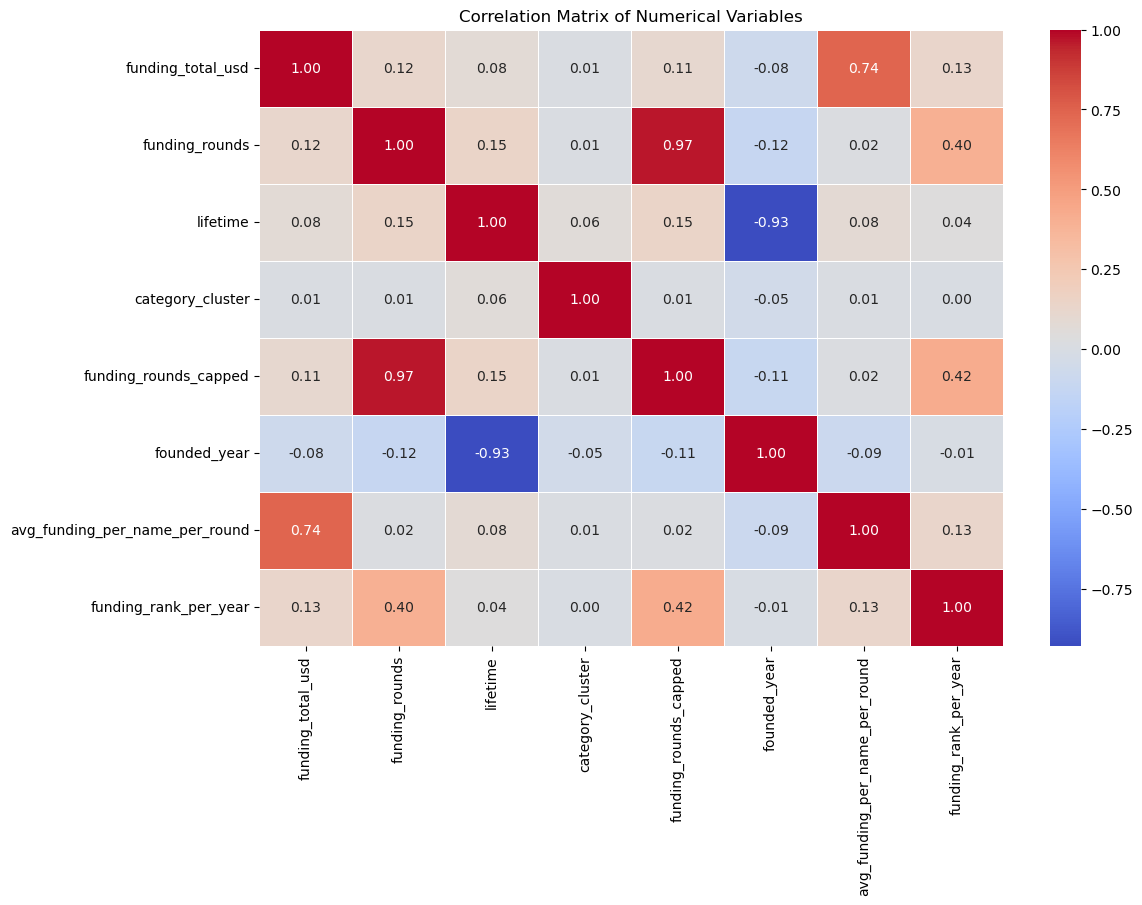

In [83]:
numeric_columns = train_data_v2.select_dtypes(include=['float64', 'int64', 'int32'])
corr_matrix = numeric_columns.corr(method='pearson')
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

## Вывод

funding_total_usd & avg_funding_per_name_per_round - это ожидаемо учитывая что большинство компаний имеет только один раунд

funding_rounds & funding_rounds_capped - это ожидаемо и при выборе фаторов для можели останеться только один (впринципе на этот фактор можно смотреть как и на категориальный)

lifetime & founded_year - чем старше компания тем дольше она живёт. обьяснимо. вприцнипе lifetime это синтетический признак из целевого и при моделировании использован не будет


# 5. Анализ категориальных признаков

In [87]:
train_data_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52516 entries, 0 to 65322
Data columns (total 23 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   name                                  52515 non-null  object        
 1   category_list                         52516 non-null  object        
 2   funding_total_usd                     52516 non-null  float64       
 3   status                                52516 non-null  object        
 4   country_code                          52516 non-null  object        
 5   state_code                            52516 non-null  object        
 6   region                                52516 non-null  object        
 7   city                                  52516 non-null  object        
 8   funding_rounds                        52516 non-null  int64         
 9   founded_at                            52516 non-null  datetime64[ns]
 10  fir

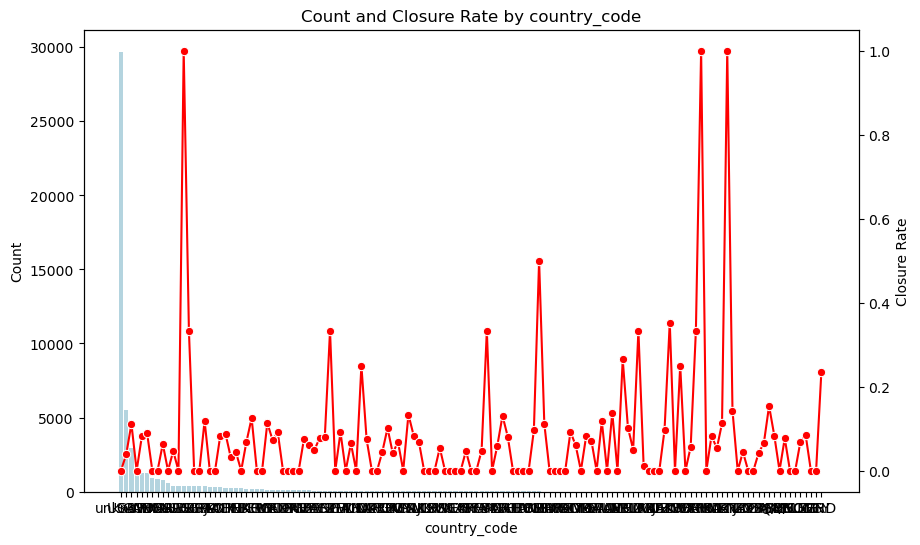

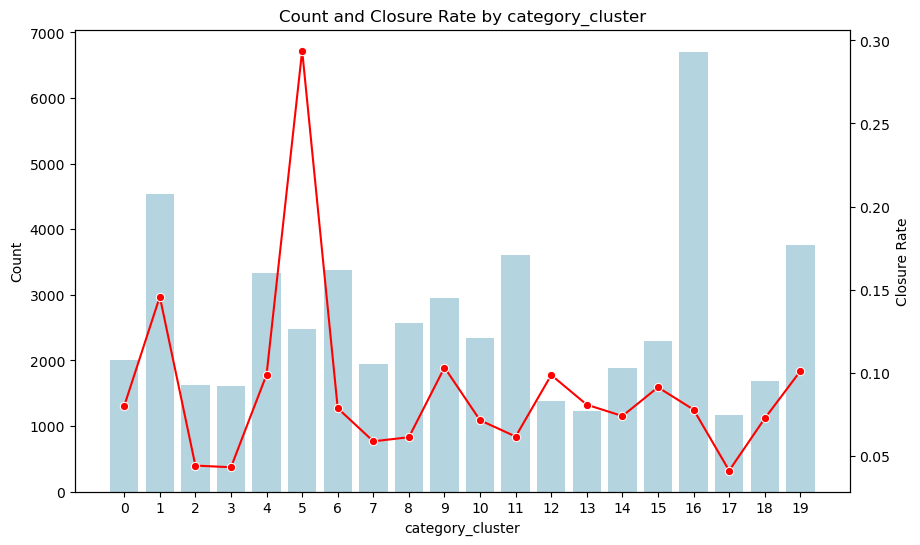

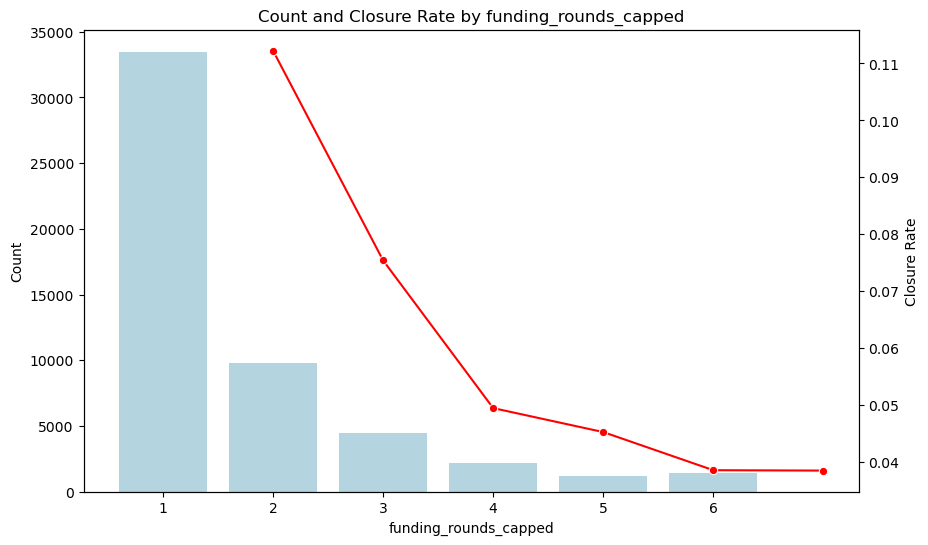

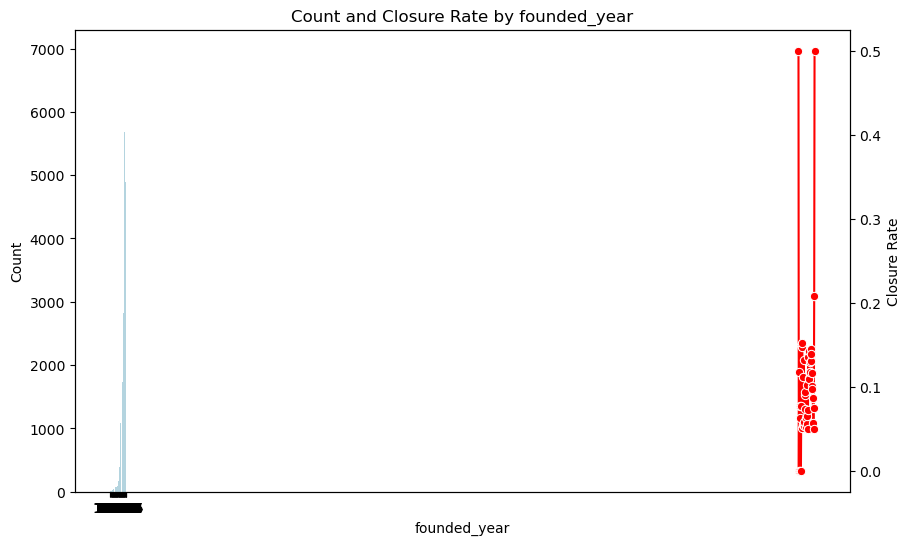

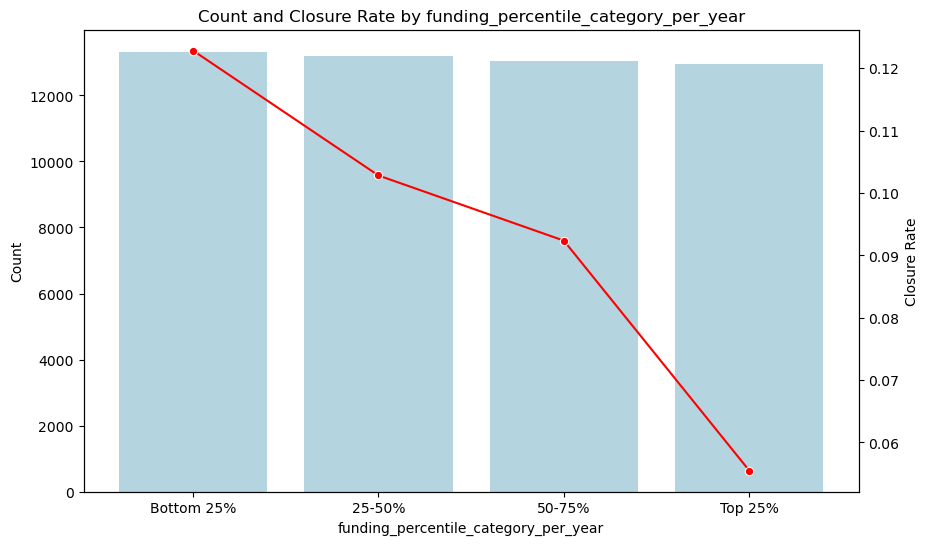

In [88]:
columns_to_plot = ['country_code', 'category_cluster', 'funding_rounds_capped', 'founded_year', 'funding_percentile_category_per_year']

for col in columns_to_plot:
    closure_rate = train_data_v2.groupby(col)['status'].apply(lambda x: (x == 'closed').mean()).reset_index()
    closure_rate.columns = [col, 'closure_rate']
    count_data = train_data_v2[col].value_counts().reset_index()
    count_data.columns = [col, 'count']
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    sns.barplot(data=count_data, x=col, y='count', ax=ax1, color='lightblue')
    ax1.set_xlabel(col)
    ax1.set_ylabel('Count')
    ax1.set_title(f'Count and Closure Rate by {col}')
    
    ax2 = ax1.twinx()
    
    sns.lineplot(data=closure_rate, x=col, y='closure_rate', marker='o', color='red', ax=ax2)
    ax2.set_ylabel('Closure Rate')

    plt.xticks(rotation=45)
    
    plt.show()

In [89]:
closure_rate_grouped = train_data_v2.groupby('founded_year').agg(
    count=('status', 'size'),
    closure_rate=('status', lambda x: (x == 'closed').mean())
).reset_index()
closure_rate_grouped

,founded_year,count,closure_rate
0,1970,2,0.500000
1,1971,13,0.000000
2,1972,17,0.117647
3,1973,13,0.076923
4,1974,11,0.000000
5,1975,16,0.062500
6,1976,20,0.150000
7,1977,18,0.000000
8,1978,26,0.076923
9,1979,39,0.051282


# 6. Отбор финального набора обучающих признаков

In [91]:
train_data_v3 = train_data_v2.drop(['name', 'category_list', 'founded_at', 'first_funding_at', 'last_funding_at', 
                                    'closed_at', 'extract_date', 'lifetime', 'source', 'category_vector', 'funding_rounds', 
                                    'funding_rank_per_year'], axis=1) 

In [92]:
test_data_v3 = test_data_v2.drop(['category_list', 'status', 'founded_at', 'first_funding_at', 'last_funding_at', 
                                    'closed_at', 'extract_date', 'lifetime', 'source', 'category_vector', 'funding_rounds', 
                                    'funding_rank_per_year'], axis=1) 

In [93]:
train_data_v3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52516 entries, 0 to 65322
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   funding_total_usd                     52516 non-null  float64 
 1   status                                52516 non-null  object  
 2   country_code                          52516 non-null  object  
 3   state_code                            52516 non-null  object  
 4   region                                52516 non-null  object  
 5   city                                  52516 non-null  object  
 6   category_cluster                      52516 non-null  int32   
 7   funding_rounds_capped                 52516 non-null  int64   
 8   founded_year                          52516 non-null  int32   
 9   avg_funding_per_name_per_round        52516 non-null  float64 
 10  funding_percentile_category_per_year  52516 non-null  category
dtypes: cate

In [94]:
train_data_v3['funding_percentile_category_per_year'].unique()

['25-50%', 'Top 25%', 'Bottom 25%', '50-75%']
Categories (4, object): ['Bottom 25%' < '25-50%' < '50-75%' < 'Top 25%']

# 7. Выбор и обучение моделей

### Пайплайн

In [97]:
#ohe_columns = ['country_code', 'state_code', 'region', 'city', 'category_cluster', 'founded_year', 'funding_rounds_capped']
ohe_columns = ['category_cluster', 'founded_year', 'funding_rounds_capped']
ord_columns = ['funding_percentile_category_per_year']
num_columns = ['funding_total_usd', 'avg_funding_per_name_per_round']


ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first'))
])

ord_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=[['Bottom 25%', '25-50%', '50-75%', 'Top 25%']], handle_unknown='use_encoded_value', unknown_value=-1)),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

num_pipe = Pipeline([
    ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler())
])

poly_pipe = Pipeline([
    ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler())
])

In [98]:
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', num_pipe, num_columns),
    ('poly', poly_pipe, num_columns)
], remainder='passthrough')

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

### Создание выборок

In [100]:
X = train_data_v3.drop(['status', 'state_code', 'region', 'city', 'country_code'], axis=1)
y = train_data_v3['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [101]:
print("Training feature set shape:", X_train.shape)
print("Testing feature set shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

Training feature set shape: (42012, 6)
Testing feature set shape: (10504, 6)
Training labels shape: (42012,)
Testing labels shape: (10504,)


### Сетка параметров для RandomizedSearchCV

In [103]:
param_grid = [
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'model__max_depth': range(2, 10),
        'model__max_features': range(2, 10),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')],
        'model__penalty': ['l2'],
        'model__C': [0.01, 0.1, 1, 10],  # Regularization parameter
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
    'model': [KNeighborsClassifier()],
    'model__n_neighbors': [3, 5, 7, 9],
    'model__weights': ['uniform', 'distance'],  # Uniform or weighted distance
    'model__p': [1, 2],  # Manhattan (p=1) or Euclidean (p=2) distance
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
#    {
#    'model': [LGBMClassifier(random_state=RANDOM_STATE)],
#    'model__n_estimators': [100, 200, 300],
#    'model__max_depth': range(3, 10),
#    'model__learning_rate': [0.01, 0.1, 0.2],
#    'model__subsample': [0.7, 0.8, 1.0],
#    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
#    }, 
    {
    'model': [SVC(random_state=RANDOM_STATE, class_weight='balanced')],
    'model__C': [0.1, 1, 10],  # Regularization parameter
    'model__kernel': ['linear', 'poly', 'rbf'],  # Kernel type
    'model__gamma': ['scale', 'auto'],  # Kernel coefficient
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
    'model': [CatBoostClassifier(random_state=RANDOM_STATE, silent=True)],
    'model__depth': range(3, 10),
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__iterations': [100, 200, 300],
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }


]

### Настройка RandomizedSearchCV

In [105]:
f1_scorer = make_scorer(f1_score, average='weighted')

In [106]:
randomized_search = RandomizedSearchCV(pipe_final, param_grid, cv=5, scoring=f1_scorer, random_state=RANDOM_STATE, n_jobs=-1)
randomized_search.fit(X_train, y_train)

C:\Users\levle\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [0.86744814 0.50743558 0.86303596 0.62958932 0.86304783        nan
 0.62975448 0.4599372  0.8636144  0.54812303]
  warnings.warn(
C:\Users\levle\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['category_cluster',
                                                                                'founded_year',
                                                                                'funding_rounds_capped']),
                                                                              ('ord',...
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']},
                                        {'model': [<catboost.core.CatBoostClassifier object at 0x00000148B4ACF790>],
                                         'model__depth': range(3, 10),
                                         'model__iterations': [100, 200, 300],
                                         'model__learning_rate': [0.01, 0.1,
                                                                  0.2],
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(f1_score, average=weighted))

In [107]:
best_params = randomized_search.best_params_
best_score = randomized_search.best_score_
best_model = randomized_search.best_estimator_

In [108]:
best_params

{'preprocessor__num__scaler': StandardScaler(),
 'model__learning_rate': 0.2,
 'model__iterations': 200,
 'model__depth': 8,
 'model': <catboost.core.CatBoostClassifier at 0x148b4acf790>}

In [109]:
best_score

0.8674481410991438

# 8. Итоговая оценка качества предсказания лучшей модели

Лучшая модель имеет эти параметры:

{'preprocessor__num__scaler': StandardScaler(),
 'model__learning_rate': 0.2,
 'model__iterations': 200,
 'model__depth': 8,
 'model': <catboost.core.CatBoostClassifier at 0x2391b2c8a90>}

 и Ф1 = 0.863

# 9. Анализ важности ее признаков

In [113]:
feature_importances = best_model.named_steps['model'].get_feature_importance()
preprocessor = best_model.named_steps['preprocessor']
transformed_feature_names = preprocessor.get_feature_names_out()
importance_df = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(20)


,Feature,Importance
70,ord__funding_percentile_category_per_year,6.856595
77,poly__funding_total_usd avg_funding_per_name_p...,5.955350
72,num__avg_funding_per_name_per_round,5.553260
78,poly__avg_funding_per_name_per_round^2,5.382948
74,poly__funding_total_usd,5.065720
76,poly__funding_total_usd^2,4.907602
4,ohe__category_cluster_5,4.641165
71,num__funding_total_usd,4.600370
61,ohe__founded_year_2013,4.182793
75,poly__avg_funding_per_name_per_round,4.104043


## Самыми важными оказались: 

признаки количества денег, сластер категорий 3 и года 2014 2010 2013

# 10. Вывод

In [116]:
test_data_v3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13125 entries, 96 to 65640
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   name                                  13125 non-null  object  
 1   funding_total_usd                     13125 non-null  float64 
 2   country_code                          13125 non-null  object  
 3   state_code                            13125 non-null  object  
 4   region                                13125 non-null  object  
 5   city                                  13125 non-null  object  
 6   category_cluster                      13125 non-null  int32   
 7   funding_rounds_capped                 13125 non-null  int64   
 8   founded_year                          13125 non-null  int32   
 9   avg_funding_per_name_per_round        13125 non-null  float64 
 10  funding_percentile_category_per_year  13125 non-null  category
dtypes: cat

In [117]:
test_data_v3_no_name = test_data_v3.drop(columns=['name'])

In [118]:
predictions = best_model.predict(test_data_v3_no_name)

C:\Users\levle\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [119]:
predictions

array(['operating', 'operating', 'operating', ..., 'operating',
       'operating', 'operating'], dtype=object)

In [120]:
predictions_df = pd.DataFrame(predictions, columns=['status'])

In [121]:
predictions_df.head()

,status
0,operating
1,operating
2,operating
3,operating
4,operating


In [122]:
test_data_v3.reset_index(drop=True, inplace=True)

In [123]:
test_data_v3_pred = pd.merge(test_data_v3, predictions_df, left_index=True, right_index=True)

In [124]:
test_data_v3_pred['status'].value_counts()

status
operating    12922
closed         203
Name: count, dtype: int64

In [225]:
test_data_v3_pred[test_data_v3_pred['status'] == 'closed']

,name,funding_total_usd,country_code,state_code,region,city,category_cluster,funding_rounds_capped,founded_year,avg_funding_per_name_per_round,funding_percentile_category_per_year,status
942,Ngo Han joint stock company,1910000.0,VNM,unknown,unknown,unknown,5,1,2005,1910000.0,Bottom 25%,closed
944,Clear Water Services,25000000.0,USA,WA,Seattle,Lynnwood,5,1,2005,25000000.0,Top 25%,closed
947,ChapDrive,2250000.0,NOR,16,Trondheim,Trondheim,5,1,2005,2250000.0,Bottom 25%,closed
954,Tracy & Michael,300000.0,USA,TX,Houston,Houston,5,1,2005,300000.0,Bottom 25%,closed
974,Gammastar Medical Group,10000000.0,CHN,unknown,unknown,unknown,7,1,2005,10000000.0,50-75%,closed
...,...,...,...,...,...,...,...,...,...,...,...,...
13057,Rehabtics,100000.0,USA,MD,Baltimore,Baltimore,3,1,2016,100000.0,25-50%,closed
13070,SpinTheCam,150000.0,USA,NY,New York City,New York,12,1,2016,150000.0,25-50%,closed
13076,Survival Media,158638.0,GBR,H8,Liverpool,Liverpool,12,1,2016,158638.0,25-50%,closed
13078,pickrset,100000.0,USA,CA,Anaheim,San Clemente,12,1,2016,100000.0,25-50%,closed


In [125]:
submit_data = test_data_v3_pred[['name', 'status']]

In [126]:
submit_data.to_csv(r'C:\Users\levle\OneDrive\Documents\Yandex_Practicum_main\Master1\M1_DS - Startups (STD)\submit_data_Lev_Lebedev.csv', index=False)